<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Text%20Generation%20-%20Shakespear/text_generation_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libs

In [ ]:
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding,
                                     LSTM, Dropout, Bidirectional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# Setup

In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 60
EPOCHS = 20
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
L2_REG = 0.005

# Utilities

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Loading Dataset

In [ ]:
!wget https://www.gutenberg.org/files/100/100-0.txt -O shakespeare.txt

--2025-08-10 08:01:41--  https://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5618733 (5.4M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   5.36M  18.5MB/s    in 0.3s    

2025-08-10 08:01:42 (18.5 MB/s) - ‘shakespeare.txt’ saved [5618733/5618733]



In [ ]:
with open("shakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [ ]:
# Cleaning text
text = clean_text(text)
print(f"Text Len: {len(text)}")

Text Len: 5031790


# Preparing Data

In [ ]:
# Creating Chars list
chars = sorted(list(set(text)))
char_to_int = {c:i for i, c in enumerate(chars)}
int_to_char = {i: c for c, i in enumerate(chars)}
n_chars = len(text)
n_vocab = len(chars)
print(f"Unique chars : {n_vocab}")

Unique chars : 48


In [ ]:
# Distribution
char_counts = pd.Series(list(text)).value_counts()
print(char_counts.head(10))

     963382
e    485890
t    354802
o    332917
a    311179
i    271051
s    268309
n    261429
h    256651
r    252644
Name: count, dtype: int64


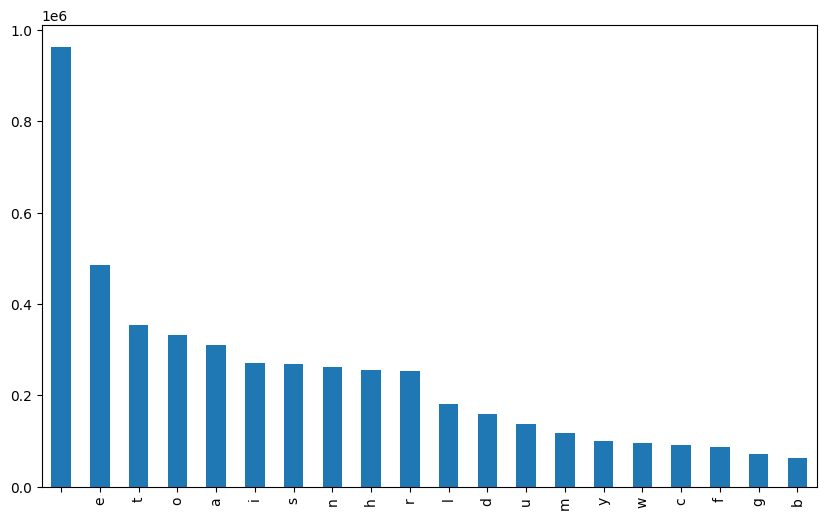

In [ ]:
plt.figure(figsize=(10, 6))
char_counts[:20].plot(kind='bar')
plt.show()

# Create sequences

In [ ]:
seq_length = MAX_SEQUENCE_LENGTH
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])

X = np.array(dataX)
y = to_categorical(dataY, num_classes=n_vocab)

# Split `Train/Test`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4025392, 50)
Shape of y_train: (4025392, 48)
Shape of X_test: (1006348, 50)
Shape of y_test: (1006348, 48)


# Define Model

In [ ]:
# Input
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH, ), name="input_layer")

# Embedding
embedding_layer = Embedding(input_dim=n_vocab, output_dim=EMBEDDING_DIM,
                            trainable=True, name="embedding_layer")(input_layer)
# LSTM 1
lstm_layer_1 = Bidirectional(LSTM(units=128, return_sequences=True,
                                  recurrent_dropout=DROPOUT_RATE,
                                  kernel_regularizer=l2(L2_REG), name="lstm_1"))(embedding_layer)
# Dropout
dropout_1 = Dropout(DROPOUT_RATE, name="dropout_1")(lstm_layer_1)
# LSTM 2
lstm_layer_2 = LSTM(units=64, return_sequences=False,
                    recurrent_dropout=DROPOUT_RATE,
                    kernel_regularizer=l2(L2_REG), name="lstm_2")(dropout_1)
# Dropout
dropout_2 = Dropout(DROPOUT_RATE, name="dropout_2")(lstm_layer_2)
# Output
output_layer = Dense(units=n_vocab,
                     activation="softmax",
                     kernel_regularizer=l2(L2_REG),
                     name="output_layer")(dropout_2)

# Model
model = Model(inputs=input_layer, outputs=output_layer, name="shakespeare_model")

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "shakespeare_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 50, 60)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       193,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 48)             │         3,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,712 (1.07 MB)

 Trainable params: 281,712 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.keras",
                             monitor='val_loss',
                             save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[early_stopping, checkpoint],
                    verbose=1)

Epoch 1/20
  4247/100635 ━━━━━━━━━━━━━━━━━━━━ 5:51:58 219ms/step - accuracy: 0.1833 - loss: 3.1286

# Evaluate Model

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generating Text

In [ ]:
def generate_text(seed_text, model, char_to_int, int_to_char, seq_length, n_chars_to_generate=100):
    generated = seed_text
    for _ in range(n_chars_to_generate):
        seq = [char_to_int.get(char, 0) for char in generated[-seq_length:]]
        seq = pad_sequences([seq], maxlen=seq_length, padding='pre')
        pred = model.predict(seq, verbose=0)[0]
        next_char_idx = np.argmax(pred)
        next_char = int_to_char[next_char_idx]
        generated += next_char
    return generated

In [ ]:
seed_text = "to be or not to be that is the question"
generated_text = generate_text(seed_text, model, char_to_int, int_to_char, MAX_SEQUENCE_LENGTH, 100)
print(f"Generated text:\n{generated_text}")